In [1]:
#import geopandas
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os, os.path
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from ipynb.fs.full.interp_data import interpolate_scenario_data

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
sns.set_style("ticks")

In [4]:
C1_c = "#649B1C"
C2_c = "#00B593"
C3_c = "#4E84D4"

- ASSUME Vietnam is in China+ instead of rest of Asia

In [4]:
crosswalk = pd.read_excel("../../data/MESSAGE/mapping_file_R10edit.xlsx",sheet_name="main")
AR6_list = crosswalk["AR6_R10"].unique()
crosswalk.head()

,Countries,R10,AR6_R10,GEM_Name,ISO
0,Algeria,Africa (R10),R10AFRICA,Algeria,DZA
1,Angola,Africa (R10),R10AFRICA,Angola,AGO
2,Benin,Africa (R10),R10AFRICA,NaN,BEN
3,Botswana,Africa (R10),R10AFRICA,NaN,BWA
4,Burkina Faso,Africa (R10),R10AFRICA,NaN,BFA


In [5]:
# load data
ar6_world = pd.read_csv("../../data/AR6_data/1668008174375-AR6_Scenarios_Database_R10_regions_v1.1.csv/AR6_Scenarios_Database_R10_regions_v1.1.csv")
ar6_scen = pd.read_excel("../../data/AR6_data/AR6_Scenarios_Database_World_v1.1/AR6_Scenarios_Database_metadata_indicators_v1.1.xlsx",sheet_name = "meta_Ch3vetted_withclimate")

In [6]:
ar6_scen_123 = ar6_scen[ar6_scen["Category"].isin(["C1","C2","C3"])]

### coal data


In [86]:
coal_hist = pd.read_csv("../../data/global_GEM/coal_plant_annual_summary.csv")
coal_hist_yr = pd.merge(coal_hist,crosswalk[["AR6_R10","ISO","GEM_Name"]],left_on="Country",right_on="GEM_Name")
coal_hist_yr = coal_hist_yr.groupby(["Year","AR6_R10"]).sum()[["MW"]]
coal_hist_yr["GW"] = coal_hist_yr["MW"]/1000
coal_hist_yr["Type"] = "Historical"
coal_hist_yr

MW         GW        Type
Year AR6_R10                                         
1927 R10EUROPE           36.00    0.03600  Historical
1928 R10EUROPE           36.00    0.03600  Historical
1929 R10EUROPE           36.00    0.03600  Historical
1930 R10EUROPE           36.00    0.03600  Historical
1931 R10EUROPE           36.00    0.03600  Historical
...                        ...        ...         ...
2022 R10MIDDLE_EAST    4385.00    4.38500  Historical
     R10NORTH_AM     216748.46  216.74846  Historical
     R10PAC_OECD      78523.98   78.52398  Historical
     R10REF_ECON      88095.50   88.09550  Historical
     R10REST_ASIA    124346.60  124.34660  Historical

[715 rows x 3 columns]

In [60]:
coal_com = pd.read_csv("../../data/global_GEM/coal_plant_current_commited.csv")
coal_com_yr = pd.merge(coal_com,crosswalk[["AR6_R10","ISO","GEM_Name"]],left_on="Country",right_on="GEM_Name")
coal_com_yr = coal_com_yr.groupby(["Year","AR6_R10"]).sum()[["MW"]]
coal_com_yr["GW"] = coal_com_yr["MW"]/1000
coal_com_yr["Type"] = "Committed"
coal_com_yr = pd.concat([coal_com_yr,coal_hist_yr.loc[[2022],:]])
coal_com_yr

MW          GW        Type
Year AR6_R10                                           
2023 R10AFRICA         51386.10    51.38610   Committed
     R10CHINA+       1125082.00  1125.08200   Committed
     R10EUROPE        135633.86   135.63386   Committed
     R10INDIA+        246956.70   246.95670   Committed
     R10LATIN_AM       16494.00    16.49400   Committed
...                         ...         ...         ...
2022 R10MIDDLE_EAST     4385.00     4.38500  Historical
     R10NORTH_AM      216748.46   216.74846  Historical
     R10PAC_OECD       78523.98    78.52398  Historical
     R10REF_ECON       88095.50    88.09550  Historical
     R10REST_ASIA     124346.60   124.34660  Historical

[399 rows x 3 columns]

In [98]:
for const_type in ["low","mid","high"]:
    coal_const = pd.read_csv("../../data/global_GEM/coal_plant_construction_"+const_type+".csv")
    sum_com_const = pd.concat([coal_const,coal_com])
    sum_com_const = pd.merge(sum_com_const,crosswalk[["AR6_R10","ISO","GEM_Name"]],left_on="Country",right_on="GEM_Name")
    sum_com_const = sum_com_const.groupby(["Year","AR6_R10"]).sum()[["MW"]]
    sum_com_const["Type"] = "Construction_"+const_type
    if const_type =="low":
        sum_com_const_all = pd.concat([sum_com_const,coal_hist_yr.loc[[2022],["MW","Type"]]])
    else:
        sum_com_const_all = pd.concat([sum_com_const_all,sum_com_const])
    sum_com_const_all["GW"] = sum_com_const_all["MW"]/1000
sum_com_const_all

MW               Type          GW
Year AR6_R10                                                  
2023 R10AFRICA         51386.10   Construction_low    51.38610
     R10CHINA+       1125082.00   Construction_low  1125.08200
     R10EUROPE        135633.86   Construction_low   135.63386
     R10INDIA+        246956.70   Construction_low   246.95670
     R10LATIN_AM       16494.00   Construction_low    16.49400
...                         ...                ...         ...
2074 R10INDIA+          8030.00  Construction_high     8.03000
     R10LATIN_AM           0.00  Construction_high     0.00000
     R10MIDDLE_EAST        0.00  Construction_high     0.00000
     R10PAC_OECD           0.00  Construction_high     0.00000
     R10REST_ASIA      10445.00  Construction_high    10.44500

[1471 rows x 3 columns]

In [7]:
ar6_world_coal = ar6_world.query("Variable=='Capacity|Electricity|Coal|w/o CCS'")#Capacity|Electricity|Coal|w/o CCS
ar6_world_coal = interpolate_scenario_data(ar6_world_coal)
ar6_world_coal = pd.merge(ar6_world_coal,ar6_scen_123[["Model","Scenario","Category"]],
                              left_on=["Model","Scenario"],right_on=["Model","Scenario"])
ar6_world_coal_melt = pd.melt(ar6_world_coal,id_vars=["Model","Scenario","Category","Region"],value_vars=ar6_world_coal.columns[5:-1],var_name="Year",value_name="CumCoal_GW").dropna()
ar6_world_coal_melt["Year"] = ar6_world_coal_melt["Year"].astype(int)
ar6_world_coal_melt = ar6_world_coal_melt.sort_values("Category")
#ar6_world_coal_melt = ar6_world_coal_melt[ar6_world_coal_melt["Year"]>=2020]
ar6_world_coal_melt

,Model,Scenario,Category,Region,Year,CumCoal_GW
218646,REMIND-MAgPIE 2.1-4.2,CEMICS_SSP2-1p5C-fullCDR,C1,R10NORTH_AM,2049,0.016280
61329,REMIND-MAgPIE 1.7-3.0,PEP_1p5C_red_eff,C1,R10AFRICA,2024,1.693100
61330,REMIND-MAgPIE 1.7-3.0,PEP_1p5C_red_eff,C1,R10CHINA+,2024,489.107340
61331,REMIND-MAgPIE 1.7-3.0,PEP_1p5C_red_eff,C1,R10EUROPE,2024,48.303700
61332,REMIND-MAgPIE 1.7-3.0,PEP_1p5C_red_eff,C1,R10INDIA+,2024,171.671180
...,...,...,...,...,...,...
171119,REMIND 2.1,TechCost-SSP2-B1100-ccsH,C3,R10REST_ASIA,2034,52.387460
171120,REMIND 2.1,TechCost-SSP2-B1100-ccsH,C3,R10ROWO,2034,0.084520
171121,REMIND 2.1,TechCost-SSP2-B1100-coalH,C3,R10AFRICA,2034,13.106920
171107,REMIND 2.1,TechCost-SSP2-B1100-bioH,C3,R10REF_ECON,2034,2.171660


In [8]:
ar6_world_coal_melt.set_index("Model").to_csv("AR6_Coal_GW_R10_capacity.csv")

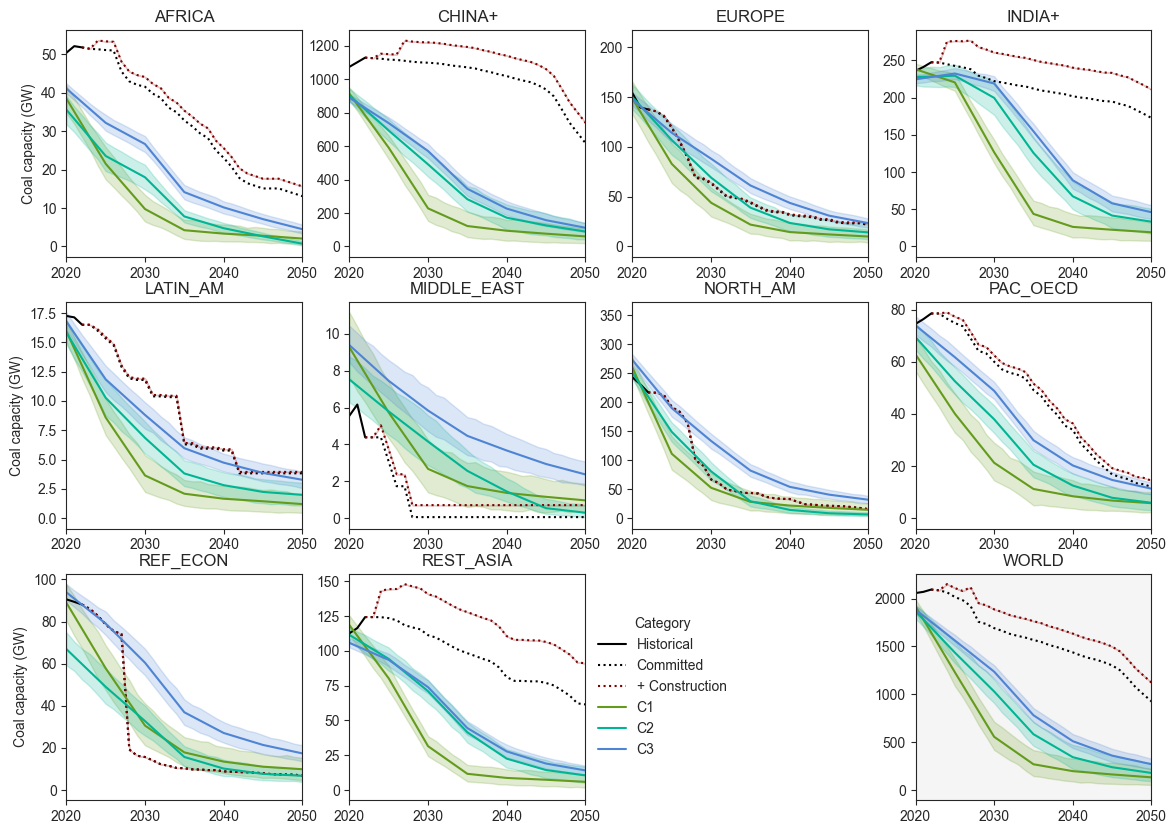

In [100]:
fig, axes = plt.subplots(3,4,figsize=(14,10))
row_list = [0,0,0,0,1,1,1,1,2,2,2]
col_list = [0,1,2,3,0,1,2,3,0,1,3]

plot_type = "2050" # "hist"
coal_hist_yr_p = coal_hist_yr.reset_index()
coal_com_yr_p = coal_com_yr.reset_index()
sum_com_const_all_p = sum_com_const_all.reset_index()

for n_r10 in np.arange(len(AR6_list)+1):
    this_ax = axes[row_list[n_r10],col_list[n_r10]]
    
    if n_r10<10:
        r10 = AR6_list[n_r10]
        ar6_world_coal_r = ar6_world_coal_melt[ar6_world_coal_melt["Region"]==r10]
        historical_coal = coal_hist_yr_p[coal_hist_yr_p["AR6_R10"]==r10]
        committed_coal = coal_com_yr_p[coal_com_yr_p["AR6_R10"]==r10]
        construction_coal = sum_com_const_all_p[sum_com_const_all_p["AR6_R10"]==r10]
    else:
        r10 = "R10WORLD"
        ar6_world_coal_r = ar6_world_coal_melt.groupby(["Year","Model","Scenario","Category"]).sum()[["CumCoal_GW"]]
        ar6_world_coal_r = ar6_world_coal_r.sort_values("Category")
        historical_coal = coal_hist_yr_p.groupby("Year").sum()[["GW"]]
        committed_coal = coal_com_yr_p.groupby("Year").sum()[["GW"]]
        construction_coal = sum_com_const_all_p.groupby(["Year","Type"]).sum()[["GW"]]
    
    sns.lineplot(x='Year', y='GW', data=historical_coal,ax=this_ax,color="black",label="Historical")
    sns.lineplot(x='Year', y='GW', data=committed_coal,ax=this_ax,color="black",label="Committed",linestyle=":")
    sns.lineplot(x='Year', y='GW', data=construction_coal,ax=this_ax,color="maroon",label="+ Construction",linestyle=":")
    sns.lineplot(x='Year', y='CumCoal_GW', hue='Category', data=ar6_world_coal_r,palette=[C1_c,C2_c,C3_c],ax=this_ax)
    this_ax.set_xlabel(None)
    this_ax.set_title(r10[3:])
    if n_r10 == 9:
        this_ax.legend(title = 'Category', loc='center left', bbox_to_anchor=(1, 0.5),frameon=False)
    else:
        this_ax.get_legend().remove()
        
    if n_r10 == 0 or n_r10 == 4 or n_r10 == 8:
        this_ax.set_ylabel("Coal capacity (GW)")
    else:
        this_ax.set_ylabel(None)
        
    if n_r10 == 10:
        this_ax.set_facecolor('whitesmoke')    
        
    if plot_type == "hist":
        this_ax.set_xlim([1930,2100])
    elif plot_type == "2050":
        this_ax.set_xlim([2020,2050])
    
fig.delaxes(axes[2,2])
fig.savefig("committed_coal_"+plot_type+"_R10.png",dpi=600, bbox_inches='tight')